In [55]:
import os
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

In [50]:
# helper functions

def add_shift(series):
    scale_factor = 0.1
    for key in series:
        if (key[-1] != 'z' and key[-1] != 'v'):
            rand_num = np.random.rand() * scale_factor - (scale_factor / 2)
            series[key] = [x + rand_num for x in series[key]]
    return series

def add_noise(series):
    scale_factor = 0.02
    for key in series:
        if (key[-1] != 'z' and key[-1] != 'v'):
            rand_num = np.random.rand() * scale_factor - (scale_factor / 2)
            series[key] = [x + (np.random.rand() * scale_factor - (scale_factor / 2)) for x in series[key]]
    return series

def rand_augment(series):
    series = add_shift(series)
    series = add_noise(series)
    return series

def series_append(series, list, keys):
    for i in range(64):
        series[keys[i]].append(float(list[i]))
    return series

def load_series(filename):
    with open(filename, 'r') as csv_in:
        csv_file = list(csv.reader(csv_in))
        series = {}
        keys = csv_file[0]
        for key in keys: series[key] = []
        for i in range(2, len(csv_file), 2):
            series = series_append(series, csv_file[i], keys)
        return [series, int((len(csv_file) - 2) / 2)]


def unroll(series):
    l = []
    for key in series:
        if (key[-1] == 'v' or key[-1] == 'z'): continue
        l += series[key]
    return l

def E3(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= (7.0/18.0)):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E2(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= (5.0/18.0)):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E1(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= (3.0/18.0)):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E0(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= (1.0/18.0)):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def eval(pred, truth):
    o_pred = []
    o_truth = []
    f_pred = []
    f_truth = []
    b_pred = []
    b_truth = []
    s_pred = []
    s_truth = []
    l_pred = []
    l_truth = []
    for p in pred:
        o_pred.append(p[0])
        f_pred.append(p[1])
        b_pred.append(p[2])
        s_pred.append(p[3])
        l_pred.append(p[4])
    for t in truth:
        o_truth.append(t[0])
        f_truth.append(t[1])
        b_truth.append(t[2])
        s_truth.append(t[3])
        l_truth.append(t[4])
    return [[E0(o_pred, o_truth), E1(o_pred, o_truth), E2(o_pred, o_truth), E3(o_pred, o_truth)],
            [E0(f_pred, f_truth), E1(f_pred, f_truth), E2(f_pred, f_truth), E3(f_pred, f_truth)],
            [E0(b_pred, b_truth), E1(b_pred, b_truth), E2(b_pred, b_truth), E3(b_pred, b_truth)],
            [E0(s_pred, s_truth), E1(s_pred, s_truth), E2(s_pred, s_truth), E3(s_pred, s_truth)],
            [E0(l_pred, l_truth), E1(l_pred, l_truth), E2(l_pred, l_truth), E3(l_pred, l_truth)]]

In [56]:
''' https://github.com/HobbitLong/SupContrast/blob/master/losses.py '''

class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-3) # MODIFIED TO AVOID NAN LOSSES

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask*log_prob).sum(1)/(mask.sum(1) + 1e-3) # MODIFIED TO AVOID NAN LOSSES

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

In [57]:
# defining siamese network

input_size = 224
fc_1 = 512
fc_2 = 384
fc_3 = 256
fc_4 = 196
fc_5 = 128
fc_6 = 64
output_size = 32
learning_rate = 0.01

class SiameseNetwork(nn.Module):
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                m.bias.data.fill_(1.0)
            
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, fc_1)
        self.fc2 = nn.Linear(fc_1, fc_2)
        self.fc3 = nn.Linear(fc_2, fc_3)
        self.fc4 = nn.Linear(fc_3, fc_4)
        self.fc5 = nn.Linear(fc_4, fc_5)
        self.fc6 = nn.Linear(fc_5, fc_6)
        self.fc7 = nn.Linear(fc_6, fc_7)
        self.fc8 = nn.Linear(fc_7, output_size)

    def forward(self, x1):
        x1 = F.leaky_relu(self.fc1(x1))
        x1 = F.leaky_relu(self.fc2(x1))
        x1 = F.leaky_relu(self.fc3(x1))
        x1 = F.leaky_relu(self.fc4(x1))
        x1 = F.leaky_relu(self.fc5(x1))
        x1 = F.leaky_relu(self.fc6(x1))
        x1 = F.leaky_relu(self.fc7(x1))
        x1 = F.leaky_relu(self.fc8(x1))

        x1 = F.normalize(x1, p=2, dim=0)

        return x1

model = SiameseNetwork()
loss_function = SupConLoss(temperature=0.07)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [58]:
# trying loading the data into 2 views (properly)

X_train = []
orig_x = []
labels = []

dir = '..\\time_series\\Time_normalized_stages\\4_final\\'
n_views = 1
for file in os.listdir(dir):
    series, num_frames = load_series(dir + file)
    label = int(file[4])
    if (label <= 2):
        labels.append(0)
    elif (label <= 5):
        labels.append(1)
    else:
        labels.append(2)
    #labels.append(float(file[4]) / 9)
    orig_x.append(series)

labels = torch.tensor(labels)

for example in orig_x:
    X_train.append(example)

#X_train = torch.tensor(X_train)
multi_view_X_train = torch.Tensor(464, 2, 224)
print(multi_view_X_train.size())

# adding views
for i in range(464):
    example = X_train[i]
    unrolled_example = unroll(example)
    multi_view = torch.Tensor(2, 224)
    multi_view[0] = torch.tensor(unrolled_example)
    multi_view[1] = torch.tensor(unroll(rand_augment(example)))

    #multi_view = torch.cat((unroll(example), rand_augment(example)))
    multi_view_X_train[i] = multi_view


features = torch.Tensor(464, 2, 32) # bsz, n_views, enc_len
for i in range(464):
    features[i][0] = model(multi_view_X_train[i][0])
    features[i][1] = model(multi_view_X_train[i][1])

print(loss_function(features, labels))

print(features.size())
print(features)


torch.Size([464, 2, 224])
tensor(6.8319, grad_fn=<MeanBackward0>)
torch.Size([464, 2, 32])
tensor([[[-0.0016, -0.0027,  0.4393,  ...,  0.0213,  0.4998, -0.0041],
         [-0.0016, -0.0027,  0.4393,  ...,  0.0213,  0.4998, -0.0041]],

        [[-0.0016, -0.0027,  0.4398,  ...,  0.0216,  0.5007, -0.0041],
         [-0.0016, -0.0027,  0.4398,  ...,  0.0216,  0.5007, -0.0041]],

        [[-0.0016, -0.0027,  0.4394,  ...,  0.0213,  0.4996, -0.0041],
         [-0.0016, -0.0027,  0.4394,  ...,  0.0212,  0.4996, -0.0041]],

        ...,

        [[-0.0015, -0.0027,  0.4395,  ...,  0.0218,  0.5002, -0.0041],
         [-0.0015, -0.0027,  0.4395,  ...,  0.0218,  0.5003, -0.0041]],

        [[-0.0016, -0.0027,  0.4395,  ...,  0.0219,  0.5007, -0.0041],
         [-0.0016, -0.0027,  0.4396,  ...,  0.0219,  0.5007, -0.0041]],

        [[-0.0015, -0.0027,  0.4394,  ...,  0.0216,  0.5002, -0.0041],
         [-0.0015, -0.0027,  0.4394,  ...,  0.0216,  0.5002, -0.0041]]],
       grad_fn=<CopySlices>)


In [59]:
# training

num_epochs = 2000

def get_features():
    features = torch.Tensor(464, 2, 32) # bsz, n_views, enc_len
    for i in range(464):
        features[i][0] = model(multi_view_X_train[i][0])
        features[i][1] = model(multi_view_X_train[i][1])
        return features

model.apply(model._init_weights)
losses = []
for epoch in range(num_epochs):
    features = get_features()
    loss = loss_function(features, labels)
    loss.backward()
    optimizer.zero_grad()
    losses.append(loss.item())

    if (epoch % 100 == 0):
        print('Epoch ' + str(epoch))
        print('Loss ' + str(loss.item()))

fig, ax = plt.subplots(1, figsize=(20,10))
ax.set_yscale('log')
plt.plot(losses)

Epoch 0
Loss 101.28821563720703
Epoch 100
Loss nan
Epoch 200
Loss nan


KeyboardInterrupt: 

In [60]:
print(losses)

[101.28821563720703, 6.852046489715576, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 

torch.Size([464, 32])
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 464 samples in 0.001s...
[t-SNE] Computed neighbors for 464 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 464 / 464
[t-SNE] Mean sigma: 0.013796
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.657890
[t-SNE] KL divergence after 1000 iterations: 0.585754


<AxesSubplot:xlabel='comp-1', ylabel='comp-2'>

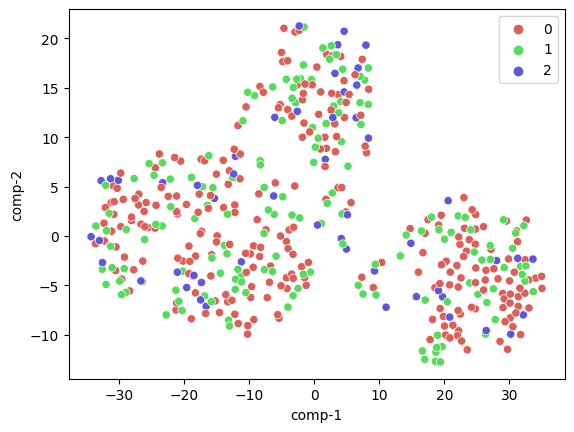

In [47]:
X = torch.Tensor(464, 1, 32)
for i in range(464):
    X[i][0] = model(multi_view_X_train[i][0])

X = torch.squeeze(X)
print(X.size())
X = np.asarray(torch.squeeze(X).tolist())

Y = np.asarray(labels.tolist())

tsne = TSNE(n_components=2, verbose=1, random_state=456)

z = tsne.fit_transform(X) 

df = pd.DataFrame()
df["y"] = Y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df)